<div class="alert alert-block alert-info">
<b>Number of points for this notebook:</b> 0
<br>
<b>Deadline:</b> March 20, 2024 (Wednesday) 23:00
</div>

# Exercise 1. Regularization techniques

This is a simple exercise, in which we will try a few methods to prevent overfitting.

## Learning goals:
* Understand various methods to prevent overfitting of neural networks.
* Experience in using regularization methods in pytorch.

In [1]:
skip_training = False  # Set this flag to True before validation and submission

In [7]:
!pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 961.7 kB/s eta 0:00:00 0:00:01


In [8]:
# During evaluation, this cell sets skip_training to True
# skip_training = True

import tools, warnings
warnings.showwarning = tools.customwarn

In [9]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

import tools

In [10]:
# Select device which you are going to use for training
device = torch.device("cpu")

In [11]:
if skip_training:
    # The models are always evaluated on CPU
    device = torch.device("cpu")

## Regression problem
We will look at a regression problem where the task is to estimate a function of one variable
$$y = f(x)$$
using a set of training examples $(x_1, y_1), \ldots, (x_n, y_n)$.

Let us first generate training examples $y_i=\sin(x_i) + n_i$ with $x_i$ drawn from the uniform distribution in $[-0.5, 0.5]$ and noise $n_i$ drawn from the Gaussian distribution.

In [12]:
np.random.seed(1)
n = 80
x = np.random.rand(n, 1)-0.5

def fun(x):
    y = np.cos(2* np.pi * x)
    y += 0.3 * np.random.randn(*x.shape)
    return y

y = fun(x)

# Convert to PyTorch tensors
x = torch.tensor(x).float()
y = torch.tensor(y).float()

Let us split the data into training, validation and test sets and plot the training and validation sets. And let us plot the data.

In [13]:
# Split the data into training and test sets
torch.manual_seed(2)
rp = torch.randperm(x.size(0))

n_train = int(x.size(0) * 0.8)
x_train, y_train = x[rp[:n_train]], y[rp[:n_train]]
x_test, y_test = x[rp[n_train:]], y[rp[n_train:]]

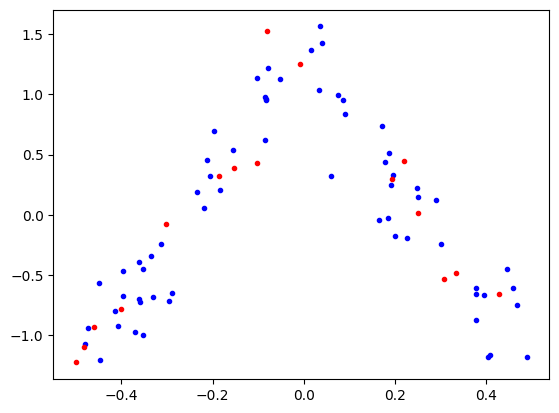

In [14]:
# Plot the data
fix, ax = plt.subplots(1)
ax.plot(x_train, y_train, 'b.')
ax.plot(x_test, y_test, 'r.')

## Define a multi-layer perceptron (MLP) network with two hidden layers

In the code below, we define a neural network architecture with:
* input dimension 1
* one hidden layer with 100 units with tanh nonlinearity
* one hidden layer with 100 units with tanh nonlinearity
* linear output layer with output dimension 1

In [15]:
class MLP(nn.Module):
    def __init__(self):
        # YOUR CODE HERE
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(1, 100)  # Input layer to 1st hidden layer (1 input, 10 units)
        self.tanh1 = nn.Tanh()  # Tanh activation for 1st hidden layer
        self.hidden2 = nn.Linear(100, 100)  # 1st hidden layer to 2nd hidden layer (10 units, 11 units)
        self.tanh2 = nn.Tanh()  # Tanh activation for 2nd hidden layer
        self.output = nn.Linear(100, 1)
        self.layers = [self.hidden1, self.tanh1, self.hidden2, self.tanh2, self.output]

    def forward(self, x):
        # YOUR CODE HERE
        
        for layer in self.layers:
            x = layer(x)
        return x

In [16]:
# Create an MLP network
mlp = MLP()
mlp.to(device)

MLP(
  (hidden1): Linear(in_features=1, out_features=100, bias=True)
  (tanh1): Tanh()
  (hidden2): Linear(in_features=100, out_features=100, bias=True)
  (tanh2): Tanh()
  (output): Linear(in_features=100, out_features=1, bias=True)
)

In [17]:
# This visualizes the function implemented by an MLP
def plot_fit(mlp, x_train, y_train):
    fig, ax = plt.subplots(1)
    ax.plot(x_train, y_train, '.')
    x_np = np.linspace(-0.5, 0.5, 100).reshape((-1, 1))
    x = torch.tensor(x_np, device=device, dtype=torch.float)
    pred = mlp.forward(x).cpu().data.numpy()
    ax.plot(x_np, pred)

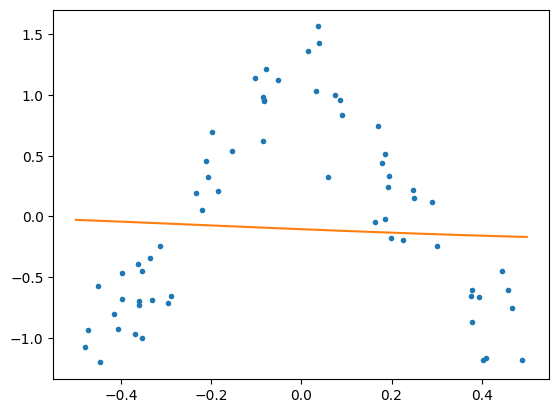

In [18]:
# Plot the function implemented by the MLP
plot_fit(mlp, x_train, y_train)

In [19]:
# This is the function to compute the loss:
def compute_loss(mlp, x, y):
    mlp.eval()
    with torch.no_grad():
        outputs = mlp.forward(x)
        loss = F.mse_loss(outputs, y)
        return loss.cpu().numpy()

# This is the function to print the progress during training
def print_progress(epoch, train_error, val_error):
    print('Epoch {}: Train error: {:.4f}, Test error: {:.4f}'.format(
        epoch, train_error, val_error))

## Train the MLP network without regularization
Training is done by minimizing the mean-squared error computed on the training data:
$$c=\sum_{i=1}^n || f(x_i) - y_i ||^2.$$

Here, we train the network:
* using all the data for computing the gradient (batch mode)
* using `n_epochs` epochs (which is equal to the number of parameter updates in the batch mode).

In [20]:
mlp = MLP()
mlp.to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.01)

In [21]:
if not skip_training:
    n_epochs = 10000
    train_errors = []  # Keep track of the training data
    val_errors = []  # Keep track of the validation data
    x = x_train.to(device)
    y = y_train.to(device)
    for epoch in range(n_epochs):

        optimizer.zero_grad()
        outputs = mlp.forward(x)
        loss = F.mse_loss(outputs, y)
        loss.backward()
        optimizer.step()

        if (epoch+1) % 500 == 0:
            train_errors.append(compute_loss(mlp, x_train, y_train))
            val_errors.append(compute_loss(mlp, x_test, y_test))
            print_progress(epoch, train_errors[-1], val_errors[-1])

    # Save the model to disk (the pth-files will be submitted automatically together with your notebook)
    tools.save_model(mlp, 'mlp_noreg.pth', confirm=False)
else:
    mlp = MLP()
    tools.load_model(mlp, 'mlp_noreg.pth', device)    

Epoch 499: Train error: 0.0554, Test error: 0.0751
Epoch 999: Train error: 0.0472, Test error: 0.0745
Epoch 1499: Train error: 0.0404, Test error: 0.0886
Epoch 1999: Train error: 0.0459, Test error: 0.0986
Epoch 2499: Train error: 0.0277, Test error: 0.1100
Epoch 2999: Train error: 0.0259, Test error: 0.1200
Epoch 3499: Train error: 0.0240, Test error: 0.1204
Epoch 3999: Train error: 0.0233, Test error: 0.1282
Epoch 4499: Train error: 0.0193, Test error: 0.1049
Epoch 4999: Train error: 0.0174, Test error: 0.1084
Epoch 5499: Train error: 0.0167, Test error: 0.1105
Epoch 5999: Train error: 0.0159, Test error: 0.1222
Epoch 6499: Train error: 0.0151, Test error: 0.1362
Epoch 6999: Train error: 0.0146, Test error: 0.1486
Epoch 7499: Train error: 0.0177, Test error: 0.1586
Epoch 7999: Train error: 0.0164, Test error: 0.1614
Epoch 8499: Train error: 0.0163, Test error: 0.1476
Epoch 8999: Train error: 0.0151, Test error: 0.1402
Epoch 9499: Train error: 0.0162, Test error: 0.1438
Epoch 9999: Tr

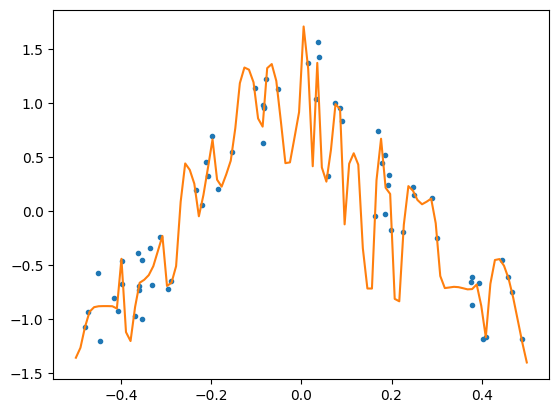

In [22]:
# Plot the final fit
plot_fit(mlp, x_train, y_train)

As you can see, the network overfits to the training data.

In [23]:
test_loss_no_regularization = compute_loss(mlp, x_test, y_test)
print("Test loss without regularization: %.5f" % test_loss_no_regularization)

Test loss without regularization: 0.15708


Let us look at the learning curves (the evolution of training and test errors during training).

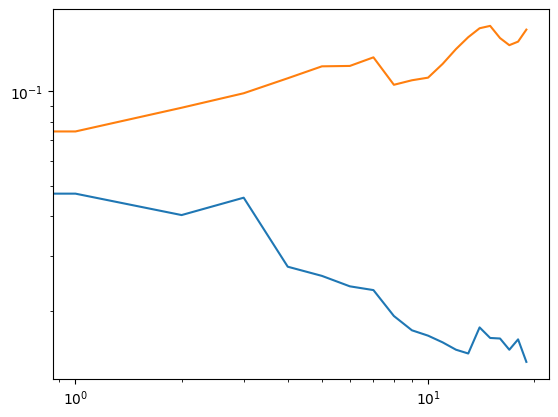

In [24]:
if not skip_training:
    fig, ax = plt.subplots(1)
    ax.loglog(train_errors)
    ax.loglog(val_errors)

 As you can see, the test error first decreases and then starts growing. This motivates the following technique to prevent overfitting.

## Early stopping

In early stopping, we stop training when the test error (or validation error) starts growing.

In the code below, we define a stopping creterion in function `stop_criterion`. Training is stopped (function returns  `True`) when the validation error is larger than the best validation error obtained so far (with given `tolerance`) for `patience` epochs.

In [25]:
class EarlyStopping:
    def __init__(self, tolerance, patience):
        """
        Args:
          patience (int):    Maximum number of epochs with unsuccessful updates.
          tolerance (float): We assume that the update is unsuccessful if the validation error is larger
                              than the best validation error so far plus this tolerance.
        """
        self.tolerance = tolerance
        self.patience = patience
    
    def stop_criterion(self, val_errors):
        """
        Args:
          val_errors (iterable): Validation errors after every update during training.
        
        Returns: True if training should be stopped: when the validation error is larger than the best
                  validation error obtained so far (with given tolearance) for patience epochs (number of consecutive epochs for which the criterion is satisfied).
                 
                 Otherwise, False.
        """
        if len(val_errors) <= self.patience:
            return False

        min_val_error = min(val_errors)
        val_errors = np.array(val_errors[-self.patience:])
        return all(val_errors > min_val_error + self.tolerance)

In [26]:
mlp = MLP()
mlp.to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)

In [27]:
# Train the network with early stopping
if not skip_training:
    n_epochs = 10000
    train_errors = []  # Keep track of the training error
    val_errors = []  # Keep track of the validation error
    early_stop = EarlyStopping(tolerance=0.01, patience=20)

    x = x_train.to(device)
    y = y_train.to(device)

    for epoch in range(n_epochs):
        optimizer.zero_grad()
        outputs = mlp.forward(x)
        loss = F.mse_loss(outputs, y)
        loss.backward()
        optimizer.step()

        train_errors.append(compute_loss(mlp, x_train, y_train))
        val_errors.append(compute_loss(mlp, x_test, y_test))

        if early_stop.stop_criterion(val_errors):
            print(val_errors[epoch])
            print('Stop after %d epochs' % epoch)
            break

        if (epoch+1) % 100 == 0:
            print_progress(epoch, train_errors[epoch], val_errors[epoch])

    # Save the model to disk (the pth-files will be submitted automatically together with your notebook)
    tools.save_model(mlp, 'mlp_early.pth', confirm=False)
else:
    mlp = MLP()
    tools.load_model(mlp, 'mlp_early.pth', device)    

Epoch 99: Train error: 0.0830, Test error: 0.0610
Epoch 199: Train error: 0.0667, Test error: 0.0544
Epoch 299: Train error: 0.0661, Test error: 0.0571
Epoch 399: Train error: 0.0660, Test error: 0.0584
Epoch 499: Train error: 0.0659, Test error: 0.0592
Epoch 599: Train error: 0.0658, Test error: 0.0598
Epoch 699: Train error: 0.0657, Test error: 0.0602
Epoch 799: Train error: 0.0655, Test error: 0.0604
Epoch 899: Train error: 0.0653, Test error: 0.0607
Epoch 999: Train error: 0.0649, Test error: 0.0610
Epoch 1099: Train error: 0.0650, Test error: 0.0617
Epoch 1199: Train error: 0.0628, Test error: 0.0615
Epoch 1299: Train error: 0.0609, Test error: 0.0628
0.063387804
Stop after 1325 epochs
Model saved to mlp_early.pth.


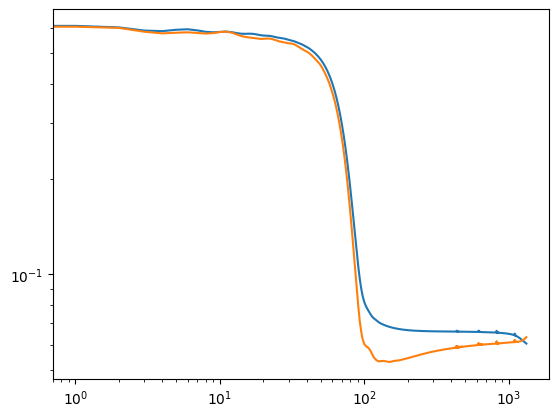

In [28]:
# Plot the learning curves
if not skip_training:
    fig, ax = plt.subplots(1)
    ax.loglog(train_errors)
    ax.loglog(val_errors)

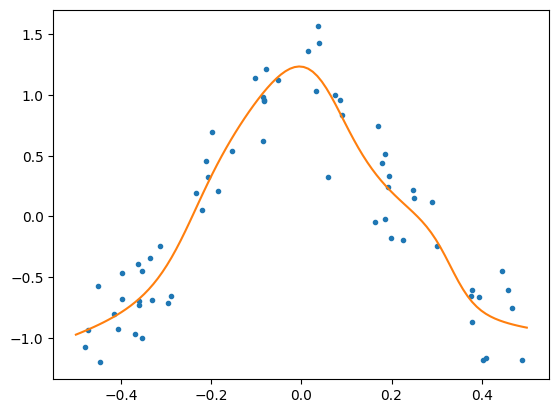

In [29]:
# Plot the final fit
plot_fit(mlp, x_train, y_train)

In [30]:
test_loss_early_stopping = compute_loss(mlp, x_test, y_test)
print("Test loss with early stopping: %.5f" % test_loss_early_stopping)

Test loss with early stopping: 0.06339


## Weight-decay regularization

Let us train the same network with L2 penalties on the weights. In PyTorch, one can add L2 penalty terms for all the parameters by providing `weight_decay` argument for most types of optimizers.

In [31]:
# Train an MLP with L2 regularization
mlp = MLP()
mlp.to(device)
del optimizer

# Create an Adam optimizer with learning rate 0.01 and weight decay parameter 0.001
# optimizer = ...
# YOUR CODE HERE
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.01, weight_decay=0.001)

In [71]:
if not skip_training:
    n_epochs = 4000
    train_errors = []
    val_errors = []

    x = x_train.to(device)
    y = y_train.to(device)

    for epoch in range(n_epochs):
        optimizer.zero_grad()
        outputs = mlp.forward(x)
        loss = F.mse_loss(outputs, y)
        loss.backward()
        optimizer.step()

        if (epoch+1) % 100 == 0:
            train_errors.append(compute_loss(mlp, x_train, y_train))
            val_errors.append(compute_loss(mlp, x_test, y_test))
            print_progress(epoch, train_errors[-1], val_errors[-1])

    # Save the model to disk (the pth-files will be submitted automatically together with your notebook)
    tools.save_model(mlp, 'mlp_wd.pth', confirm=False)
else:
    mlp = MLP()
    tools.load_model(mlp, 'mlp_wd.pth', device)    

Epoch 99: Train error: 0.0661, Test error: 0.0611
Epoch 199: Train error: 0.0661, Test error: 0.0611
Epoch 299: Train error: 0.0661, Test error: 0.0610
Epoch 399: Train error: 0.0661, Test error: 0.0610
Epoch 499: Train error: 0.0660, Test error: 0.0609
Epoch 599: Train error: 0.0660, Test error: 0.0609
Epoch 699: Train error: 0.0660, Test error: 0.0608
Epoch 799: Train error: 0.0660, Test error: 0.0608
Epoch 899: Train error: 0.0660, Test error: 0.0607
Epoch 999: Train error: 0.0660, Test error: 0.0606
Epoch 1099: Train error: 0.0660, Test error: 0.0606
Epoch 1199: Train error: 0.0660, Test error: 0.0605
Epoch 1299: Train error: 0.0660, Test error: 0.0604
Epoch 1399: Train error: 0.0660, Test error: 0.0604
Epoch 1499: Train error: 0.0660, Test error: 0.0603
Epoch 1599: Train error: 0.0660, Test error: 0.0603
Epoch 1699: Train error: 0.0660, Test error: 0.0602
Epoch 1799: Train error: 0.0660, Test error: 0.0602
Epoch 1899: Train error: 0.0660, Test error: 0.0601
Epoch 1999: Train error

In [72]:
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


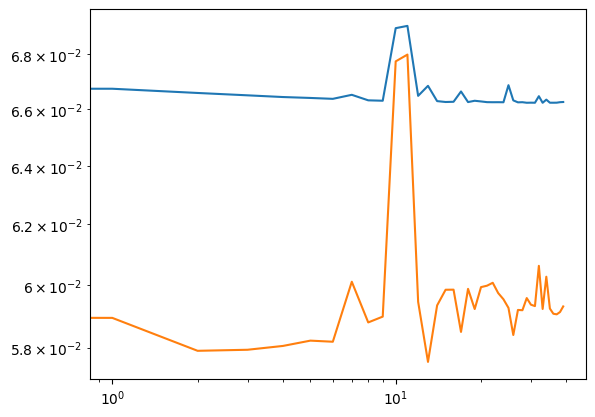

In [34]:
# Plot the learning curves (the evolution of the following quantities during training)
if not skip_training:
    fig, ax = plt.subplots(1)
    ax.loglog(train_errors)
    ax.loglog(val_errors)

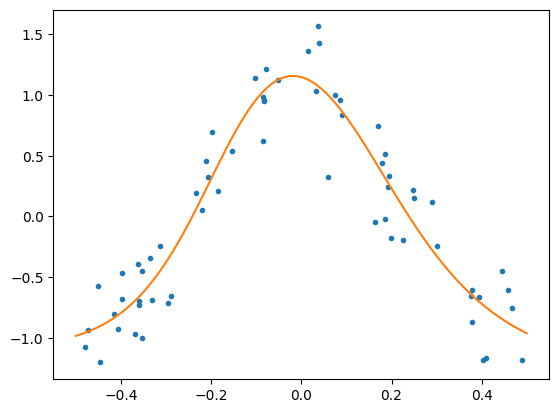

In [35]:
# Plot the final fit
plot_fit(mlp, x_train, y_train)

In [36]:
test_loss_weight_decay = compute_loss(mlp, x_test, y_test)
print("Test loss with weight decay: %.5f" % test_loss_weight_decay)
assert test_loss_weight_decay < 0.11

Test loss with weight decay: 0.05931


## Injecting noise to inputs

One way to improve generalization is to add noise to the inputs. So, we update the parameters of $f$ using the gradient of the following function
$$c= \sum_{i=1}^n || f(x_i + n_i) - y_i ||^2$$
where $n_i$ is a noise instance.

In the code below, implement adding Gaussian noise with standard deviation to the given inputs.

In [48]:
def add_noise(x, noise_std):
    """Add Gaussian noise to a PyTorch tensor.
    
    Args:
      x (tensor): PyTorch tensor of inputs.
      noise_std (float): Standard deviation of the Gaussian noise.
      
    Returns:
      x: Tensor with Gaussian noise added.
    """
    # YOUR CODE HERE
    y = x.clone().detach()
    y += torch.rand(x.shape) * noise_std
    return y
    

In [51]:
# Let's test shapes
x = torch.randn(10)
x_with_noise = add_noise(x, 0.5)
assert x_with_noise.shape == x.shape, f"Bad x_with_noise.shape: {x_with_noise.shape}"

In [52]:
mlp = MLP()
mlp.to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.01)

In [53]:
# Train MLP with injecting noise to inputs
if not skip_training:
    n_epochs = 4000
    train_errors = []
    val_errors = []
    x = x_train.to(device)
    y = y_train.to(device)

    for epoch in range(n_epochs):
        optimizer.zero_grad()
        outputs = mlp.forward(add_noise(x, noise_std=0.05))
        loss = F.mse_loss(outputs, y)
        loss.backward()
        optimizer.step()

        if (epoch+1) % 100 == 0:
            train_errors.append(compute_loss(mlp, x_train, y_train))
            val_errors.append(compute_loss(mlp, x_test, y_test))
            print_progress(epoch, train_errors[-1], val_errors[-1])

    # Save the model to disk (the pth-files will be submitted automatically together with your notebook)
    tools.save_model(mlp, 'mlp_noiseinj.pth', confirm=False)
else:
    mlp = MLP()
    tools.load_model(mlp, 'mlp_noiseinj.pth', device)    

Epoch 99: Train error: 0.0761, Test error: 0.0644
Epoch 199: Train error: 0.0753, Test error: 0.0710
Epoch 299: Train error: 0.0747, Test error: 0.0780
Epoch 399: Train error: 0.0735, Test error: 0.0814
Epoch 499: Train error: 0.0706, Test error: 0.0842
Epoch 599: Train error: 0.0704, Test error: 0.0885
Epoch 699: Train error: 0.0789, Test error: 0.0979
Epoch 799: Train error: 0.0680, Test error: 0.0895
Epoch 899: Train error: 0.0695, Test error: 0.0905
Epoch 999: Train error: 0.0649, Test error: 0.0893
Epoch 1099: Train error: 0.0681, Test error: 0.0931
Epoch 1199: Train error: 0.0703, Test error: 0.0884
Epoch 1299: Train error: 0.0721, Test error: 0.0915
Epoch 1399: Train error: 0.0623, Test error: 0.0833
Epoch 1499: Train error: 0.0716, Test error: 0.0891
Epoch 1599: Train error: 0.0723, Test error: 0.0903
Epoch 1699: Train error: 0.0766, Test error: 0.0915
Epoch 1799: Train error: 0.0675, Test error: 0.0805
Epoch 1899: Train error: 0.0703, Test error: 0.0921
Epoch 1999: Train error

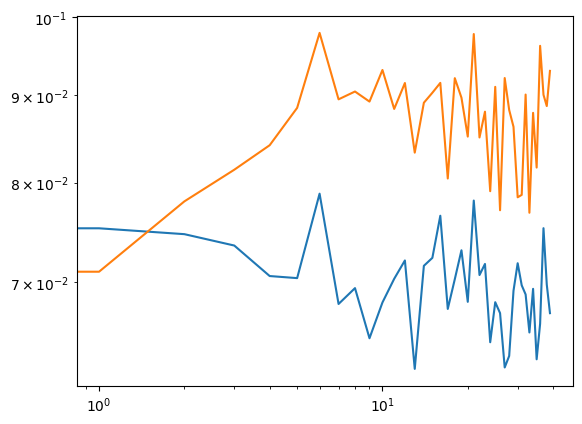

In [54]:
# Plot the learning curves
if not skip_training:
    fig, ax = plt.subplots(1)
    ax.loglog(train_errors)
    ax.loglog(val_errors)

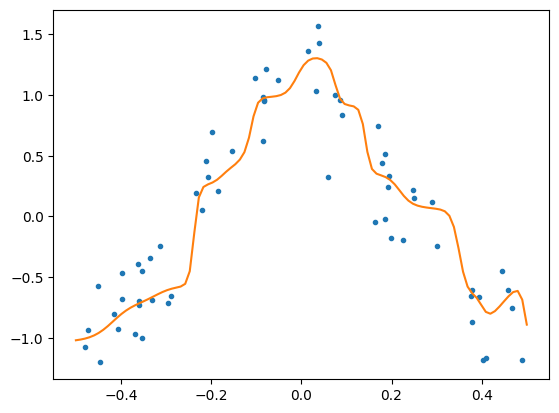

In [55]:
# Plot the final fit
plot_fit(mlp, x_train, y_train)

In [56]:
# Let's look at the test loss
test_loss_inj_noise = compute_loss(mlp, x_test, y_test)
print("Test loss with noise injection: %.5f" % test_loss_inj_noise)
assert test_loss_inj_noise < 0.13
assert optimizer.defaults['weight_decay'] == 0

Test loss with noise injection: 0.09302


## Dropout

Another way to improve generalization is to use dropout. In the cell below, define an MLP with exactly the same architecture as previously but with using `nn.Dropout` layers (with dropout probability 0.2) after each `tanh`
nonlinearity. 

In [57]:
class MLPDropout(nn.Module):
    def __init__(self):
        # YOUR CODE HERE
        super(MLPDropout, self).__init__()
        self.hidden1 = nn.Linear(1, 100)
        self.tanh1 = nn.Tanh()
        self.dropout1 = nn.Dropout(0.2)
        self.hidden2 = nn.Linear(100, 100)
        self.tanh2 = nn.Tanh()
        self.dropout2 = nn.Dropout(0.2)
        self.output = nn.Linear(100, 1)
        self.layers = [self.hidden1, self.tanh1, self.dropout1, self.hidden2, self.tanh2, self.dropout2, self.output]
        
    def forward(self, x):
        # YOUR CODE HERE
        for layer in self.layers:
            x = layer(x)
        return x

In [58]:
mlp = MLPDropout()
print(mlp)

MLPDropout(
  (hidden1): Linear(in_features=1, out_features=100, bias=True)
  (tanh1): Tanh()
  (dropout1): Dropout(p=0.2, inplace=False)
  (hidden2): Linear(in_features=100, out_features=100, bias=True)
  (tanh2): Tanh()
  (dropout2): Dropout(p=0.2, inplace=False)
  (output): Linear(in_features=100, out_features=1, bias=True)
)


In [59]:
mlp = MLPDropout()
mlp.to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.01)

In [60]:
# Train MLP with dropout
if not skip_training:
    #scheduler = StepLR(optimizer, step_size=100, gamma=0.95)
    n_epochs = 4000
    train_errors = []
    val_errors = []

    x = x_train.to(device)
    y = y_train.to(device)

    for epoch in range(n_epochs):
        #scheduler.step()
        mlp.train()
        optimizer.zero_grad()
        outputs = mlp.forward(x)
        loss = F.mse_loss(outputs, y)
        loss.backward()
        optimizer.step()

        if (epoch+1) % 100 == 0:
            mlp.eval()
            train_errors.append(compute_loss(mlp, x_train, y_train))
            val_errors.append(compute_loss(mlp, x_test, y_test))
            print_progress(epoch, train_errors[-1], val_errors[-1])

    # Save the model to disk (the pth-files will be submitted automatically together with your notebook)
    tools.save_model(mlp, 'mlp_dropout.pth', confirm=False)
else:
    mlp = MLPDropout()
    tools.load_model(mlp, 'mlp_dropout.pth', device)    

Epoch 99: Train error: 0.0810, Test error: 0.1005
Epoch 199: Train error: 0.0789, Test error: 0.0919
Epoch 299: Train error: 0.0707, Test error: 0.0875
Epoch 399: Train error: 0.0710, Test error: 0.0812
Epoch 499: Train error: 0.0652, Test error: 0.0841
Epoch 599: Train error: 0.0642, Test error: 0.0846
Epoch 699: Train error: 0.0713, Test error: 0.0890
Epoch 799: Train error: 0.0725, Test error: 0.1080
Epoch 899: Train error: 0.0635, Test error: 0.0793
Epoch 999: Train error: 0.0682, Test error: 0.0803
Epoch 1099: Train error: 0.0626, Test error: 0.0802
Epoch 1199: Train error: 0.0714, Test error: 0.0811
Epoch 1299: Train error: 0.0633, Test error: 0.0782
Epoch 1399: Train error: 0.0653, Test error: 0.0800
Epoch 1499: Train error: 0.0647, Test error: 0.0807
Epoch 1599: Train error: 0.0626, Test error: 0.0793
Epoch 1699: Train error: 0.0640, Test error: 0.0802
Epoch 1799: Train error: 0.0621, Test error: 0.0746
Epoch 1899: Train error: 0.0632, Test error: 0.0718
Epoch 1999: Train error

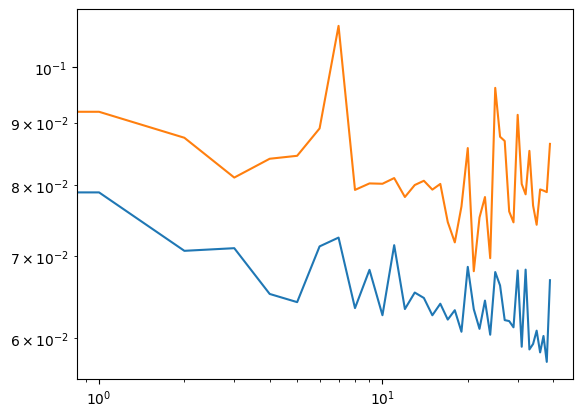

In [61]:
# Plot the learning curves
if not skip_training:
    fig, ax = plt.subplots(1)
    ax.loglog(train_errors)
    ax.loglog(val_errors)

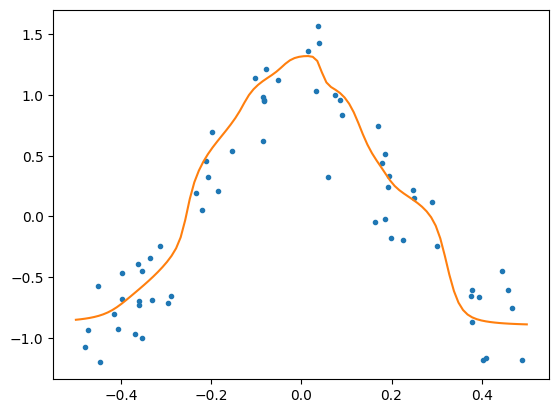

In [62]:
# Plot the final fit
mlp.eval()
plot_fit(mlp, x_train, y_train)

In [63]:
# Let's look at the test loss
test_loss_dropout = compute_loss(mlp, x_test, y_test)
print("Test loss with dropout: %.5f" % test_loss_dropout)
assert test_loss_dropout < 0.13
assert optimizer.defaults['weight_decay'] == 0

Test loss with dropout: 0.08648


## Reducing model capacity

Another simple way to reduce overfitting is to reduce the capacity of the model. Let us use for the same regression task a much smaller network: an MLP with one hidden layer with five units, tanh nonlinearity in the hidden layer and a linear output layer.

In [64]:
class MLPSmall(nn.Module):
    def __init__(self):
        super(MLPSmall, self).__init__()
        # YOUR CODE HERE
        self.hidden1 = nn.Linear(1, 5)
        self.tanh1 = nn.Tanh()
        self.output = nn.Linear(5, 1)
        self.layers = [self.hidden1, self.tanh1, self.output]
    
    def forward(self, x):
        # YOUR CODE HERE
        for layer in self.layers:
            x = layer(x)

        return x

In [65]:
mlp = MLPSmall()
mlp.to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)

In [66]:
if not skip_training:
    n_epochs = 10000
    train_errors = []  # Keep track of the training data
    val_errors = []  # Keep track of the validation data

    x = x_train.to(device)
    y = y_train.to(device)

    for epoch in range(n_epochs):
        optimizer.zero_grad()
        outputs = mlp.forward(x)
        loss = F.mse_loss(outputs, y)
        loss.backward()
        optimizer.step()

        if (epoch+1) % 500 == 0:
            train_errors.append(compute_loss(mlp, x_train, y_train))
            val_errors.append(compute_loss(mlp, x_test, y_test))
            print_progress(epoch, train_errors[-1], val_errors[-1])

    # Save the model to disk (the pth-files will be submitted automatically together with your notebook)
    tools.save_model(mlp, 'mlp_small.pth', confirm=False)
else:
    mlp = MLPSmall()
    tools.load_model(mlp, 'mlp_small.pth', device)    

Epoch 499: Train error: 0.5789, Test error: 0.5654
Epoch 999: Train error: 0.5345, Test error: 0.5092
Epoch 1499: Train error: 0.3567, Test error: 0.3167
Epoch 1999: Train error: 0.1292, Test error: 0.0977
Epoch 2499: Train error: 0.0820, Test error: 0.0618
Epoch 2999: Train error: 0.0741, Test error: 0.0571
Epoch 3499: Train error: 0.0704, Test error: 0.0562
Epoch 3999: Train error: 0.0683, Test error: 0.0569
Epoch 4499: Train error: 0.0671, Test error: 0.0584
Epoch 4999: Train error: 0.0665, Test error: 0.0600
Epoch 5499: Train error: 0.0662, Test error: 0.0614
Epoch 5999: Train error: 0.0662, Test error: 0.0622
Epoch 6499: Train error: 0.0661, Test error: 0.0625
Epoch 6999: Train error: 0.0661, Test error: 0.0624
Epoch 7499: Train error: 0.0661, Test error: 0.0621
Epoch 7999: Train error: 0.0661, Test error: 0.0619
Epoch 8499: Train error: 0.0661, Test error: 0.0617
Epoch 8999: Train error: 0.0661, Test error: 0.0615
Epoch 9499: Train error: 0.0661, Test error: 0.0613
Epoch 9999: Tr

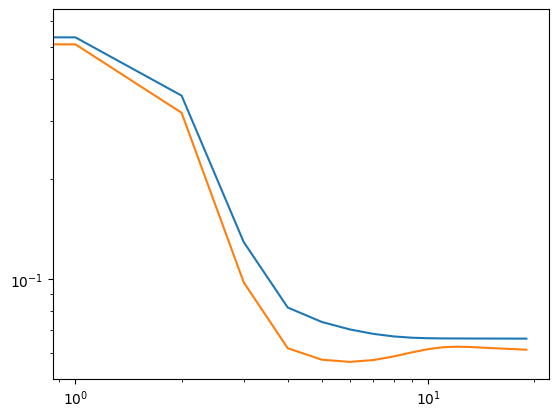

In [67]:
# Plot the learning curves
if not skip_training:
    fig, ax = plt.subplots(1)
    ax.loglog(train_errors)
    ax.loglog(val_errors)

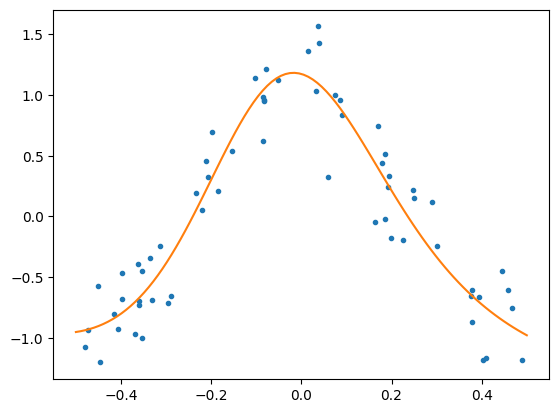

In [68]:
# Plot the final fit
mlp.eval()
plot_fit(mlp, x_train, y_train)

In [69]:
# Let's look at the test loss
test_loss_small = compute_loss(mlp, x_test, y_test)
print("Test loss by reducing model capacity: %.5f" % test_loss_small)
assert test_loss_small < 0.11
assert optimizer.defaults['weight_decay'] == 0

Test loss by reducing model capacity: 0.06117


In [70]:
# We can summarize the results obtained with different regularization methods:
print('No regularization: %.5f' % test_loss_no_regularization)
print('Early stopping:    %.5f' % test_loss_early_stopping)
print('Weight decay:      %.5f' % test_loss_weight_decay)
print('Noise injection:   %.5f' % test_loss_inj_noise)
print('Dropout:           %.5f' % test_loss_dropout)
print('Small network:     %.5f' % test_loss_small)

No regularization: 0.15708
Early stopping:    0.06339
Weight decay:      0.05931
Noise injection:   0.09302
Dropout:           0.08648
Small network:     0.06117


The values of the hyperparameters (parameters of the training procedure) may have major impact on the results. One has to find the best hyperparameter values which is usually done by measuring the performance on the validation set.